In [85]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from activ.pipeline import score_clusters
import matplotlib.pyplot as plt
import scipy
from matplotlib.backends.backend_pdf import PdfPages
import h5py
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch
from collections import Counter

In [192]:
data = load_data()
oc_features = data.outcome_features
oc = data.outcomes
oc.shape

(247, 177)

In [ ]:
# GOSE_OverallScore3m 
gose = oc[:,4]
gose

In [92]:
np.array(list(Counter(gose).values()))/len(gose)

1.0000000000000002

In [52]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'

In [53]:
f = h5py.File(file, 'r')

In [124]:
umap_dims = f['umap_dimensions'][:]
score = f['score'][:]
norm_score = f['norm_score'][:]
clusters = f['clusters'][:]
cluster_sizes = f['cluster_sizes'][:]

In [125]:
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]

In [126]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='mahalanobis')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
mean.shape

(30381,)

In [127]:
cluster_sizes

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [148]:
def calc_entropy(gose_scores):
    probs = np.array(list(Counter(gose_scores).values()))/len(gose_scores)
    return entropy(probs, base=2.0)

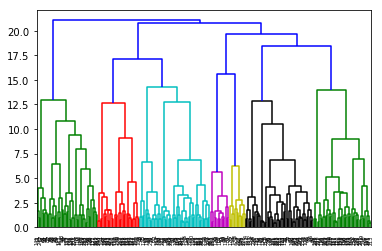

In [191]:
values = []
tree = _sch.linkage(mean, method='ward')
_sch.dendrogram(tree)
labels = _sch.cut_tree(tree, cluster_sizes)
hold = list()
for ii,c in enumerate(cluster_sizes):
    entropies = []
    for label in np.unique(labels[:,ii]):
        scores = gose[labels[:,ii]==label]
        ent = calc_entropy(scores)
        entropies.append(ent)

    v = np.mean(entropies)
    values.append(v)
hold.append(gose)


Text(0,0.5,'Entropy')

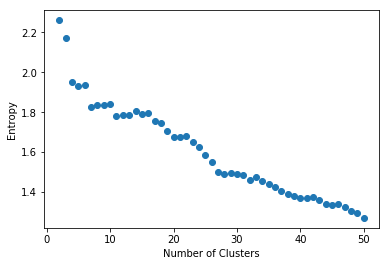

In [157]:
plt.plot(cluster_sizes, values, 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Entropy')

In [116]:
values = []
labels = _sch.cut_tree(_sch.linkage(mean, method='ward'), cluster_sizes)
for ii,c in enumerate(cluster_sizes):
    entropies = []
    for label in np.unique(labels[:,ii]):
        indices = [index for index, value in enumerate(labels[:,ii]) if value == label]
        scores = list(map(int, gose[indices]))
        probs = []
        for s in set(scores):
            prob = scores.count(s)/len(scores)
            probs.append(prob)
        entropies.append(entropy(probs))
    values.append(np.mean(entropies))

Text(0,0.5,'Entropy')

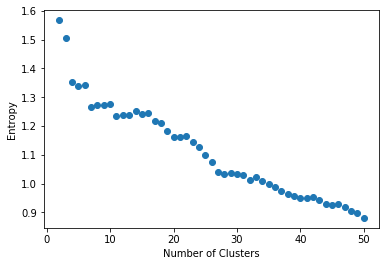

In [117]:
plt.plot(cluster_sizes, values, 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Entropy')

In [153]:
calc_entropy(gose)

2.1809392884866039

In [152]:
calc_entropy([4,4]) + calc_entropy([8,7])

1.0

In [180]:
calc_entropy([4,4,8,6,3])

1.9219280948873625

In [182]:
calc_entropy([6,4,3,8])

2.0